In [1]:
import Pkg; Pkg.activate(".")

  Activating environment at `~/PhD/DomDec/DomDecOT.jl/notebooks/Project.toml`


In [2]:
using MultiScaleOT
using DomDecOT
using SparseArrays
using Plots
default(size = (300, 300), legend = :none, aspect_ratio = :equal, ticks = false, showaxis = false)
import LinearAlgebra: dot, ⋅, norm
using SparseArrays

In [3]:
function get_initial_plan_and_tfinal(key, N)
    cellsize = 1
    μ = ones(N); normalize!(μ)
    ν = copy(μ)
    x1 = collect(1.:N)./N
    X = flat_grid(x1)
    Y = flat_grid(x1)
    mu = GridMeasure(X, μ, (N,))
    nu = GridMeasure(Y, ν, (N,))
    if key == "product"
        K = ν .* μ'
        tfinal = 1.2
    elseif key == "flipped"
        K = [Float64(i == N+1-j)/N for i in 1:N, j in 1:N]
        tfinal = 1.2
    end
    return DomDecPlan(mu, nu, K, cellsize), tfinal
end

function compute_epsilon(N, ; schedule = "squared")
    if schedule == "constant"
        return 2/32^2
    elseif schedule == "linear"
        return (2/32)/N
    elseif schedule == "squared"
        return 2/N^2
    end
end

default_params = (; DomDecOT.DEFAULT_PARAMETERS..., parallel_iteration = true)

(epsilon = 1.0, solver_max_error = 1.0e-6, solver_max_error_rel = true, solver_max_iter = 10000, solver_verbose = true, solver_truncation = 1.0e-15, balance = true, truncate = true, truncate_Ythresh = 1.0e-15, truncate_Ythresh_rel = true, parallel_iteration = true)

In [4]:
# Type of initialization
#key = "flipped"
key = "product"
N = 32
c(x,y) = l22(x,y)
solver = domdec_sinkhorn_autofix_log!
ε = compute_epsilon(N; schedule = "squared")
iters = []
P0, tfinal = get_initial_plan_and_tfinal(key, N)
P0

DomDecPlan with cellsize 1 and marginals
    mu: 1D GridMeasure with gridshape (32,)
    nu: 1D GridMeasure with gridshape (32,)

In [5]:
P = deepcopy(P0)
iter_params = (; default_params..., epsilon = ε, solver_verbose = false)
plans = []
anim = @animate for k in 1:Int(ceil(N*tfinal))+1
    A = plan_to_dense_matrix(P, c, false)
    heatmap(A, clim = (0, 1/2N), title = "t = $(round((k-1)/N, digits = 2))")
    # Iterate
    Npart = length(P.composite_cells)
    P.epsilon = iter_params[:epsilon]
    k0 = (k-1)%Npart+1
    iterate_parallel!(P, k0, c, solver, iter_params)
end

Animation("/tmp/jl_NHNrci", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000031.png", "000032.png", "000033.png", "000034.png", "000035.png", "000036.png", "000037.png", "000038.png", "000039.png", "000040.png"])

┌ Info: Saved animation to 
│   fn = /home/ismael/PhD/DomDec/DomDecOT.jl/notebooks/tmp.gif
└ @ Plots /home/ismael/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOT.jl/notebooks/tmp.gif")
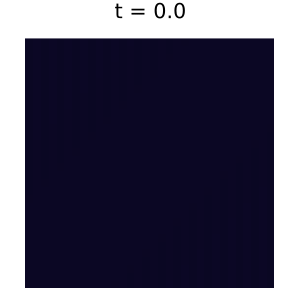

In [6]:
gif(anim, fps = 4)

In [7]:
iters_dict = Dict()
for N in [32, 64, 128]
    for refinement_schedule in ["squared", "linear", "constant"]
        println("Computing iterations for N = ", N, ", schedule = ", refinement_schedule)
        plans = []
        ε = compute_epsilon(N,schedule = refinement_schedule)
        P, tfinal = get_initial_plan_and_tfinal(key, N)
        iter_params = (; default_params..., epsilon = ε, solver_verbose = false)
        push!(iters, plan_to_dense_matrix(P, c))
        N_iter = Int(ceil(N*tfinal))
        Npart = length(P.composite_cells)
        for k in 1:N_iter
            P.epsilon = iter_params[:epsilon]
            k0 = (k-1)%Npart+1
            iterate_parallel!(P, k0, c, solver, iter_params)
            push!(plans, plan_to_dense_matrix(P, c))
        end
        push!(iters_dict, (N, refinement_schedule) => plans)
    end
end

Computing iterations for N = 32, schedule = squared
Computing iterations for N = 32, schedule = linear
Computing iterations for N = 32, schedule = constant
Computing iterations for N = 64, schedule = squared
Computing iterations for N = 64, schedule = linear
Computing iterations for N = 64, schedule = constant
Computing iterations for N = 128, schedule = squared
Computing iterations for N = 128, schedule = linear
Computing iterations for N = 128, schedule = constant


In [8]:
titles = Dict("squared"=>"ε∼1/n^2", "linear"=>"ε∼1/n", "constant"=>"ε∼1")
anim = @animate for t in 0:1/128:tfinal
    plots = []
    for (i,N) in enumerate([32, 64, 128])
        for (j, refinement_schedule) in enumerate(["squared", "linear", "constant"])
            k = Int(floor(N*t))+1
            
            p = heatmap(iters_dict[(N, refinement_schedule)][k], clim = (0,2/N^(3/2)); titlefontsize = 12, )
            if i == 1
                title!(" ")
                if j == 1
                    annotate!(p, 0, 1.17N,text("t=$(round(t, digits = 3)),", 12, :left))
                end
                
                annotate!(p, N, 1.17N,text("$(titles[refinement_schedule])", 12, :right))
            end
            if j == 1
                ylabel!("n=$N", ylabelfontsize=12)
            end
            push!(plots, p)
            
        end
    end
    plot(plots..., layout = (3,3), size = (600,600), suptitle = t)
end

Animation("/tmp/jl_UgFLdi", ["000001.png", "000002.png", "000003.png", "000004.png", "000005.png", "000006.png", "000007.png", "000008.png", "000009.png", "000010.png"  …  "000145.png", "000146.png", "000147.png", "000148.png", "000149.png", "000150.png", "000151.png", "000152.png", "000153.png", "000154.png"])

┌ Info: Saved animation to 
│   fn = /home/ismael/PhD/DomDec/DomDecOT.jl/notebooks/tmp.gif
└ @ Plots /home/ismael/.julia/packages/Plots/PomtQ/src/animation.jl:114


Plots.AnimatedGif("/home/ismael/PhD/DomDec/DomDecOT.jl/notebooks/tmp.gif")
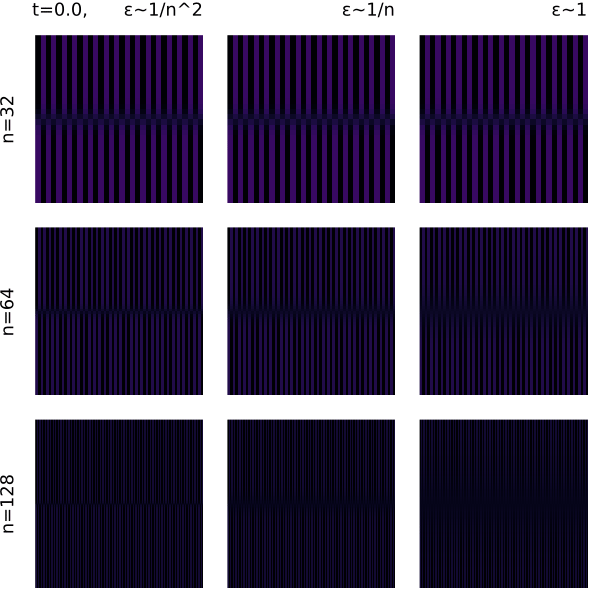

In [9]:
gif(anim, fps = 4)